## Environment Setup
For Colab, the helper folders need to be copied over from the repo. The below cell does this automatically.

In [ ]:
%%bash

# Check if the environment variable exists
if [ -n "$COLAB_RELEASE_TAG" ] || [ -n "$COLAB_GPU" ]; then
    echo "Running on Google Colab. Cloning repository into temp folder..."
    git clone https://github.com/TuebingenAICenter/agent-tutorial.git /tmp/tmp_repo
    echo "Moving all helpers to project root..."
    mv /tmp/tmp_repo/chat_with_X_utils .
    mv /tmp/tmp_repo/images .
    mv /tmp/tmp_repo/env.example ./.env
    mv /tmp/tmp_repo/requirements.txt .
else
    echo "Not running on Google Colab. Skipping git clone."
fi

# The installation block runs regardless of environment.
echo "Checking for requirements.txt and installing required packages..."

# Check if requirements.txt exists in the current directory
if [ -f "requirements.txt" ]; then
    # Attempt to install with 'uv', and if it fails (exit code != 0), use 'pip' as a fallback.
    if command -v uv &> /dev/null; then
        echo "uv detected. Installing with uv..."
        uv pip install -r requirements.txt
    else
        echo "Installing with pip..."
        pip install -r requirements.txt
    fi
else
    echo "ERROR! requirements.txt not found! Please check for errors..."
fi

### Setting API key
The following cell sets the API key for accessing LLMs. The prompt will ask for `OPENROUTER_API_KEY` if it has not been set in the .env file.

Optionally an OpenAI key can be set in the `.env` file.

In [ ]:
import dotenv
import os
from getpass import getpass

# Load environment variables from a .env file if it exists
dotenv.load_dotenv()
  
# Prompt for the API key if it's not already set
if not os.getenv("OPENROUTER_API_KEY"):
    os.environ["OPENROUTER_API_KEY"] = getpass(
        "Enter your OPENROUTER API key: "
    )
            
if not os.environ["OPENROUTER_API_KEY"]:
    print("WARNING: API key not set. Please run this cell again!")

# Example 01: Basic LangGraph Chatbot & Tool

**What:** A simple code example for a basic chatbot that has access to a multiply function.

**Why:** To show you (i) basic LangGraph flow, (ii) how all the concepts we discussed stitch together

**Live:** Follow along with notebook 01 from our repository. Ideally, we can all run this easily $\implies$ setup for advanced examples later.

## What we plan to create:

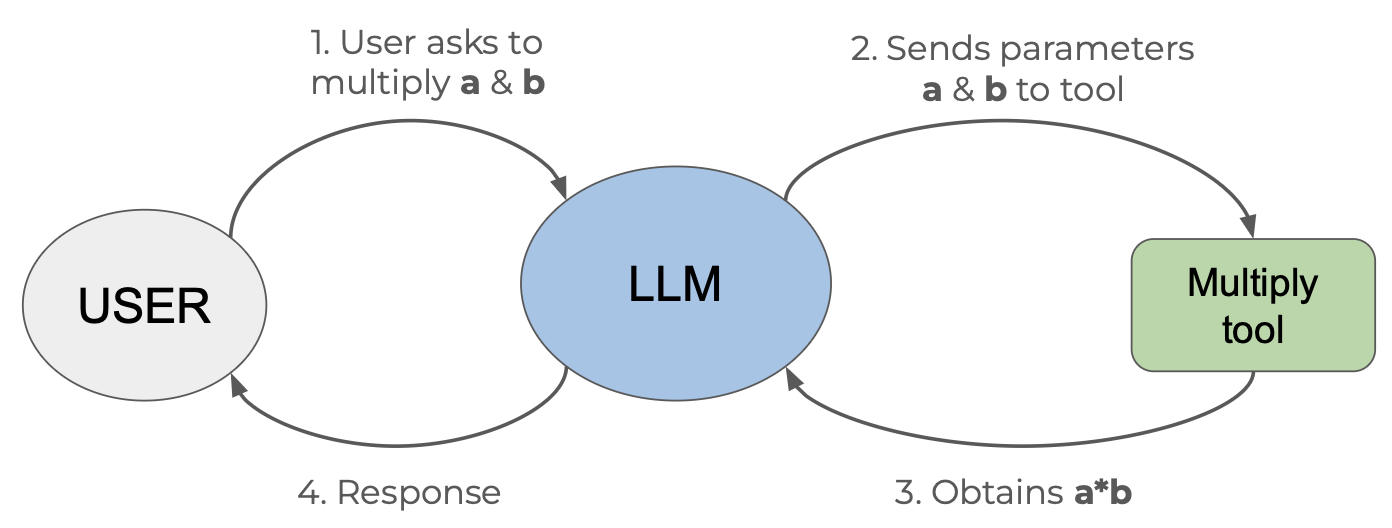

## What it looks like in LangGraph

<img src="./images/cond-nb-1.png">

## Setup

### Importing necessary packages

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

from langchain_core.tools import tool

<!-- ### Setting API key and initializing LLM -->
### Initializing LLM

In [ ]:
if os.getenv("OPENAI_API_KEY"):
    llm = ChatOpenAI(
        model="gpt-4.1-mini-2025-04-14",
        temperature=0.7,
        openai_api_key=os.getenv("OPENAI_API_KEY"),
    )
else:
    llm = ChatOpenAI(
        model="gpt-4.1-mini-2025-04-14",
        temperature=0.7,
        base_url="https://openrouter.ai/api/v1",
        api_key=os.environ["OPENROUTER_API_KEY"],
    )

### Helper functions

In [5]:
from chat_with_X_utils.print_utils import (
    print_messages_from_stream_event as _print_messages_from_stream_event,
    print_messages_from_state as _print_messages_from_state,
)

## Basic chatbot

### [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

A typed dictionary that all nodes (and conditional edges) operate on. It stores information that persists between nodes.


In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


#### [Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)
Reducers define how keys of the state should be updated (instead of overridden).

### [StateGraph](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph)

The "design" graph that operates on the `State` (not compiled yet!). 

Uses a `State` object to define the structure of our agentic system (which is a state machine).

In [7]:
graph_builder = StateGraph(State)

### Tools 

Tools are functions designed to be called by an LLM. 

- We can easily build our own using the [`@tool()` decorator](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html). which wraps a function to make it easily callable. 

- What's nice is that we can provide the docs_string as a "readable" to the LLM along with the function name using `@tool(parse_docstring=True)`.

Note that the LLM needs to support tool calling for this functionality.

#### Tool API

In [8]:
@tool(parse_docstring=True) #parse_docstring=True allows to add descriptions for the arguments
def multiply_two_integers(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args: 
        a: The first integer to multiply.
        b: The second integer to multiply.
    """
    return a*b

multiply_two_integers.args_schema.model_json_schema()

{'description': 'Multiply two integers.',
 'properties': {'a': {'description': 'The first integer to multiply.',
   'title': 'A',
   'type': 'integer'},
  'b': {'description': 'The second integer to multiply.',
   'title': 'B',
   'type': 'integer'}},
 'required': ['a', 'b'],
 'title': 'multiply_two_integers',
 'type': 'object'}

In [9]:
tools = [multiply_two_integers]
llm_with_tools = llm.bind_tools(tools)

### [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)

Functions that operate on `State` and ouptut updates to it. Usually LLM calls, that may use tools.

Here we [invoke](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#invoke-a-runnable) the LLM, which is a [runnable](https://python.langchain.com/docs/concepts/runnables/). A runnable is the foundational high-level LangChain abstraction that represents any language model, output parser, retriever, or compiled LangGraph graphs, amongst others. Invoking it means accepting an input and returning an output ("run button").

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

#### [ToolNode](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)

A pre-built tool box which becomes a node in our graph. Runs the tools called in the last [AIMessage](https://python.langchain.com/docs/concepts/messages/#aimessage) and appends the resulting [ToolMessage(s)](https://python.langchain.com/docs/concepts/messages/#toolmessage) to the "messages" state key (or a custom key passed into ToolNode)

In [11]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=[multiply_two_integers])
graph_builder.add_node("multiply_tool", tool_node)


### [Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node)

Specifies how an agentic system should transition between nodes.

#### [Conditional edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)

Defined by a function operating on the state which outputs the next node to transition to.
Here, [`tools_condition`](https://langchain-ai.github.io/langgraph/reference/agents/?h=toolnode#langgraph.prebuilt.tool_node.tools_condition) outputs either "tools" if a tool call is detected in the last [AIMessage](https://python.langchain.com/docs/concepts/messages/#aimessage) or `END` if it isn't.

In [12]:
def multiply_if_llm_wants_to(state: State):
    nxt = tools_condition(state)
    if nxt == END:
        return END
    return "multiply_tool" 
        

# graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_conditional_edges("chatbot", multiply_if_llm_wants_to, ["multiply_tool", END])

graph_builder.add_edge("multiply_tool", "chatbot")
graph_builder.add_edge(START, "chatbot")

### [Checkpointer](https://langchain-ai.github.io/langgraph/concepts/memory/#short-term-memory)

This is an in-memory checkpointer (just uses RAM) so that the LLM does not forget what we said in the previous messages. We can also use an SQL DB for this or whatever we like.

Note that we define a `config` object here, which contains a `thread_id`. This governs the thread for which we checkpoint.

In [13]:
from langgraph.checkpoint.memory import MemorySaver
config = {"configurable": {"thread_id": "1"}}
memory = MemorySaver()

### Compile and Test

Now `graph` is an instance of `CompiledStateGraph`, and we can run things.

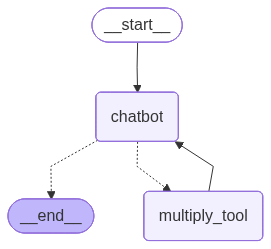

In [14]:
from IPython.display import Image, display

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def stream_graph_updates(user_input: str, _printed: set):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config, stream_mode="values"):
        _print_messages_from_stream_event(event, _printed)


_printed = set()
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input, _printed)

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ hi                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Hello! How can I assist you today?                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ Please multiply 2317 with 8793                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: multiply_two_integers                                                                             │
│    Args: {                                                                                                      │
│   "a": 2317,                                                                                                    │
│   "b": 8793                                                                                                     │
│ }                                                                                                               │
│    ID: call_BckKuCu95Z8g33ieGSBxOr0J                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 20373381                                                                                                        │
│                                                                                                                 │
│ Call ID: call_BckKuCu95Z8g33ieGSBxOr0J                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ The result of multiplying 2317 by 8793 is 20,373,381. If you have any other questions or need further           │
│ assistance, feel free to ask!                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Goodbye!
